In [1]:
import matplotlib.pyplot as plt

# Dynamic information - Update before running
# Assumes biweekly contributions grows proportionally to annual raise
starting_balance = 0
biweekly_contribution = 850
annual_raise = 0.04
market_growth_rate = 0.08
current_age = 22
retirement_age = 50

In [2]:
# Static information
balance_all = [starting_balance] * 26 * (retirement_age - current_age)
balance_income = [starting_balance] * 26 * (retirement_age - current_age)
starting_capital = [starting_balance] * 26 * (retirement_age - current_age)

In [3]:
# Run simulation
tail_index = (retirement_age - current_age) * 26
for i in range(1, tail_index):
    contribution = biweekly_contribution * (1 + annual_raise) ** int(i / 26)
    balance_all[i] = balance_all[i-1] * (1 + market_growth_rate / 365) ** 14 + contribution
    balance_income[i] = balance_income[i-1] + contribution

# Calculate maximum retirement withdrawal
retirement_withdrawal_max = balance_all[tail_index - 1] * (1 + market_growth_rate / 365) ** 30 - balance_all[tail_index - 1]

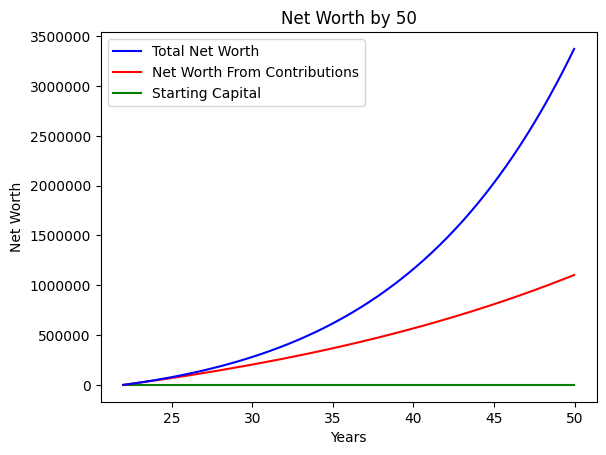

Maximum monthly withdrawal after retirement to maintin net worth: 22248.93


In [4]:
# Plot net worth
years_range = list(map(lambda x: x / 26, range(current_age * 26, current_age * 26 + len(balance_all))))
plt.plot(years_range, balance_all, 'b', label='Total Net Worth', zorder=2)
plt.plot(years_range, balance_income, 'r', label='Net Worth From Contributions', zorder=1)
plt.plot(years_range, starting_capital, 'g', label='Starting Capital', zorder=0)

plt.ticklabel_format(axis='y', style='plain')
plt.title("Net Worth by " + str(retirement_age))
plt.xlabel('Years')
plt.ylabel('Net Worth')
plt.legend(loc='upper left')
plt.show()

# Print maximum retirement withdrawal
print("Maximum monthly withdrawal after retirement to maintin net worth: \033[1m" + str(round(retirement_withdrawal_max, 2)) + "\033[1m")